# Heart Disease Data Analysis

This notebook performs a comprehensive analysis of the `heart_disease.csv` dataset, covering data cleaning, missing value imputation (MICE), exploratory data analysis (EDA), feature engineering, and machine learning modeling.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-learn imports
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline
sns.set_theme(style="whitegrid")

OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Data Loading & Initial Exploration

In [5]:
try:
    df = pd.read_csv('heart_disease.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Error: heart_disease.csv not found.")

Data loaded successfully. Shape: (4999, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


## 2. Data Cleaning
Removing duplicate rows.

In [6]:
initial_rows = len(df)
df.drop_duplicates(inplace=True)
display(df.head())
print(f"Removed {initial_rows - len(df)} duplicate rows.")

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


Removed 6 duplicate rows.


## 3. Handling Missing Data (MICE)
Checking for missing values and applying MICE imputation. If no missing values exist, we simulate some to demonstrate the capability.

In [7]:
missing_counts = df.isnull().sum()
if missing_counts.sum() == 0:
    print("No missing values found. Simulating missing data for MICE demonstration...")
    # Simulate 1% missing data in BMI and SleepTime
    np.random.seed(42)
    mask_bmi = np.random.rand(len(df)) < 0.01
    mask_sleep = np.random.rand(len(df)) < 0.01
    df.loc[mask_bmi, 'BMI'] = np.nan
    df.loc[mask_sleep, 'SleepTime'] = np.nan
    print("Introduced synthetic missing values in BMI and SleepTime.")

print("Applying MICE Imputation...")
numeric_cols_impute = ['BMI', 'SleepTime', 'PhysicalHealth', 'MentalHealth']
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df[numeric_cols_impute] = mice_imputer.fit_transform(df[numeric_cols_impute])
print("Missing values handled using MICE.")

Applying MICE Imputation...
Missing values handled using MICE.


## 4. Outlier Detection
Using IQR method to detect outliers in BMI.

In [8]:
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]
print(f"Number of BMI outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

Number of BMI outliers detected: 117 (2.34%)


## 5. Exploratory Data Analysis (EDA)

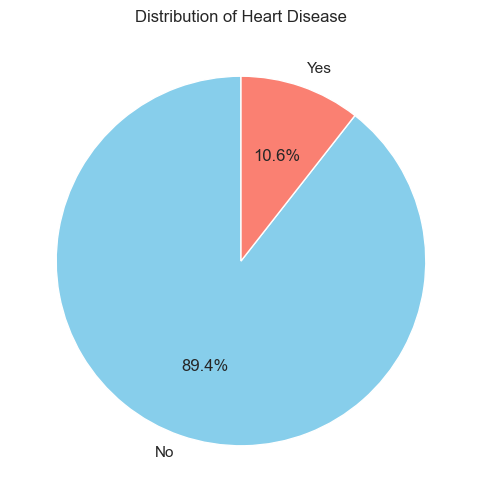

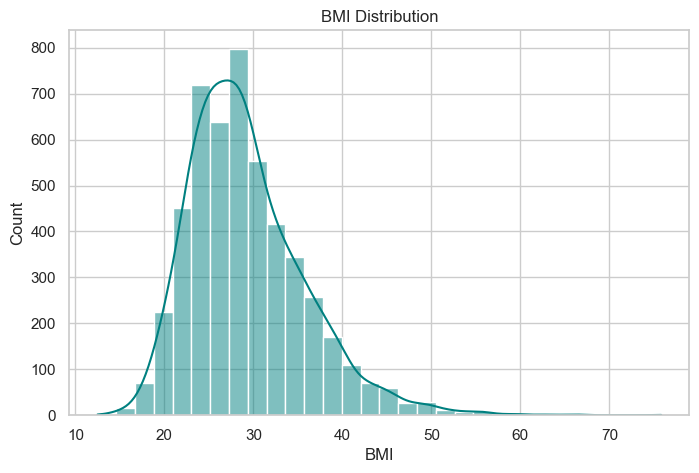

C:\Users\khôi\AppData\Local\Temp\ipykernel_22068\2333288766.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Smoking', data=df, palette='viridis')


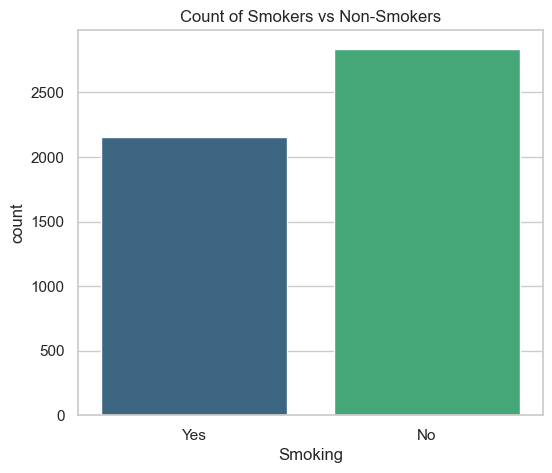

C:\Users\khôi\AppData\Local\Temp\ipykernel_22068\2333288766.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HeartDisease', y='BMI', data=df, palette='coolwarm')


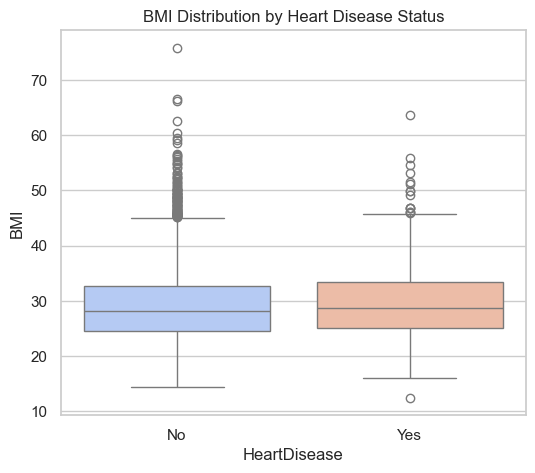

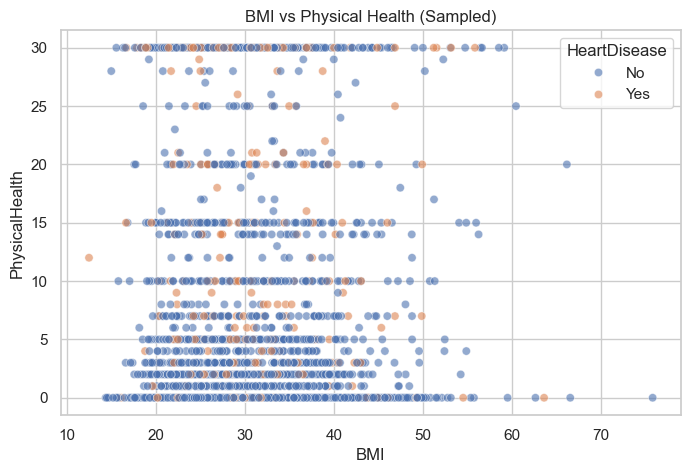

In [9]:
# 5.1 Pie Chart: Target Distribution
plt.figure(figsize=(6, 6))
df['HeartDisease'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title('Distribution of Heart Disease')
plt.ylabel('')
plt.show()

# 5.2 Histogram: BMI Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['BMI'], bins=30, kde=True, color='teal')
plt.title('BMI Distribution')
plt.show()

# 5.3 Bar Chart: Smoking Status
plt.figure(figsize=(6, 5))
sns.countplot(x='Smoking', data=df, palette='viridis')
plt.title('Count of Smokers vs Non-Smokers')
plt.show()

# 5.4 Box Plot: BMI by Heart Disease
plt.figure(figsize=(6, 5))
sns.boxplot(x='HeartDisease', y='BMI', data=df, palette='coolwarm')
plt.title('BMI Distribution by Heart Disease Status')
plt.show()

# 5.5 Scatter Plot: BMI vs Physical Health
plt.figure(figsize=(8, 5))
sample_df = df.sample(min(5000, len(df)), random_state=42)
sns.scatterplot(x='BMI', y='PhysicalHealth', hue='HeartDisease', data=sample_df, alpha=0.6)
plt.title('BMI vs Physical Health (Sampled)')
plt.show()

## 6. Correlation Matrix

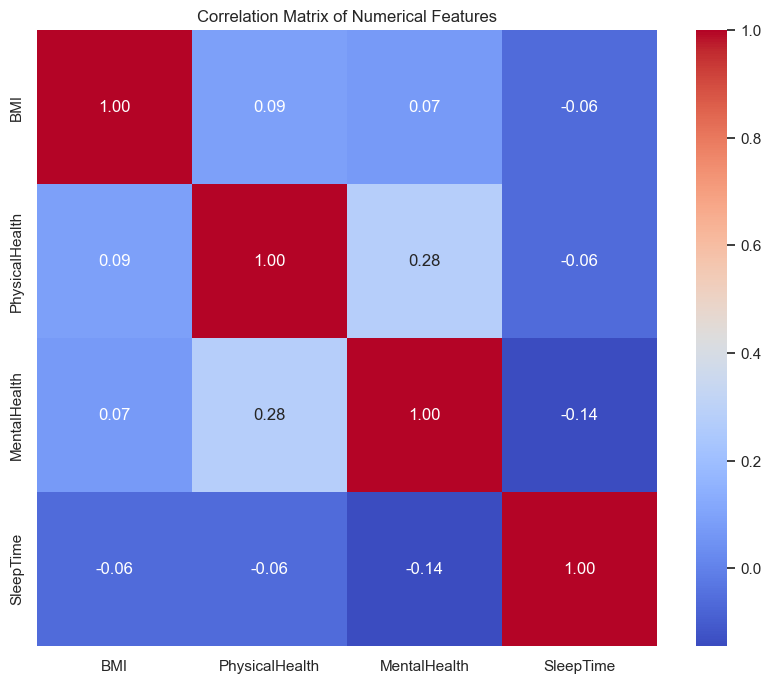

In [10]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 7. Feature Engineering
Applying One-Hot Encoding to categorical variables and Standard Scaling to numerical variables.

In [11]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease'].apply(lambda x: 1 if x == 'Yes' else 0)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

## 8. Model Development & Feature Importance
Training a Random Forest Classifier and extracting feature importance.

C:\Users\khôi\AppData\Local\Temp\ipykernel_22068\1983532162.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='magma')


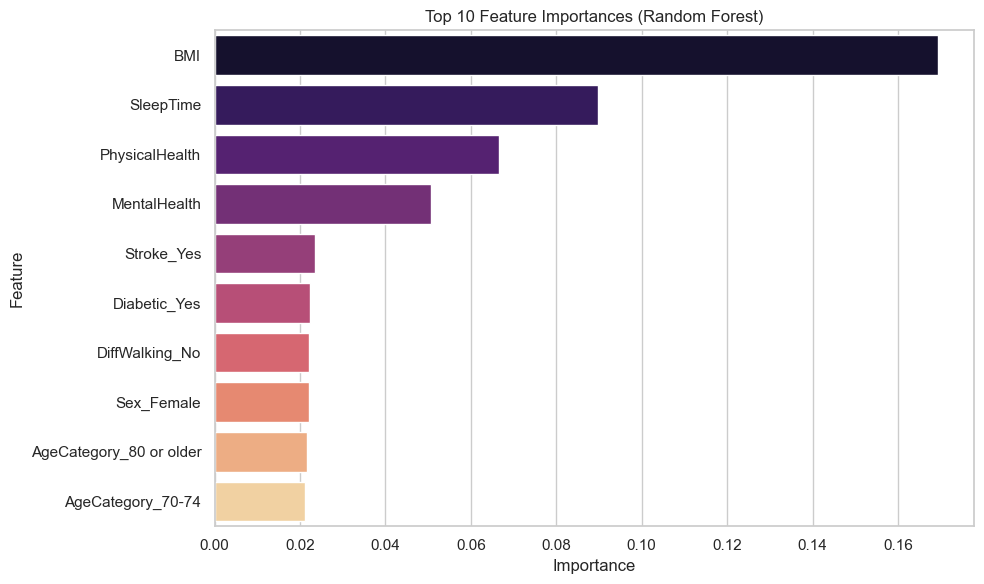

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1))])
rf_model.fit(X_train, y_train)

importances = rf_model.named_steps['classifier'].feature_importances_
ohe = rf_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(ohe_feature_names)

feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='magma')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

## 9. Model Comparison & Evaluation
Comparing Random Forest with Logistic Regression.


--- Random Forest Results ---
Accuracy: 0.8959
Precision: 0.5455
Recall: 0.1132
F1 Score: 0.1875


<Figure size 800x600 with 0 Axes>

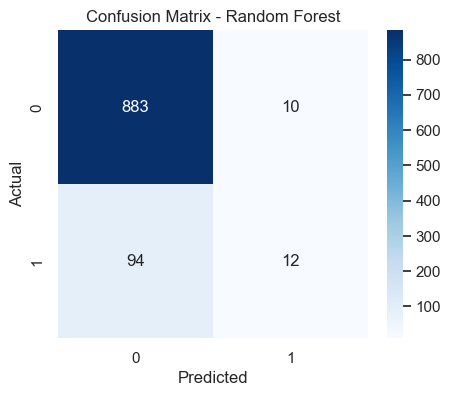


--- Logistic Regression Results ---
Accuracy: 0.9059
Precision: 0.7143
Recall: 0.1887
F1 Score: 0.2985


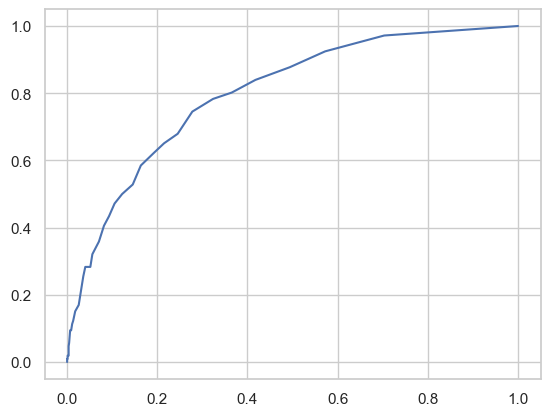

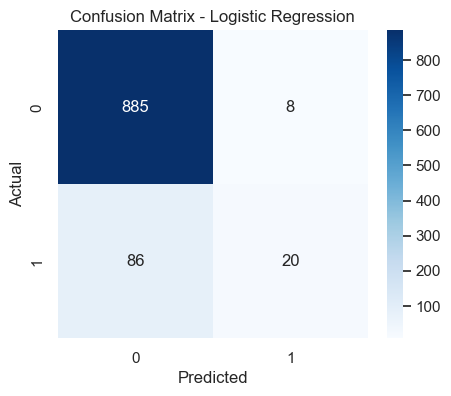

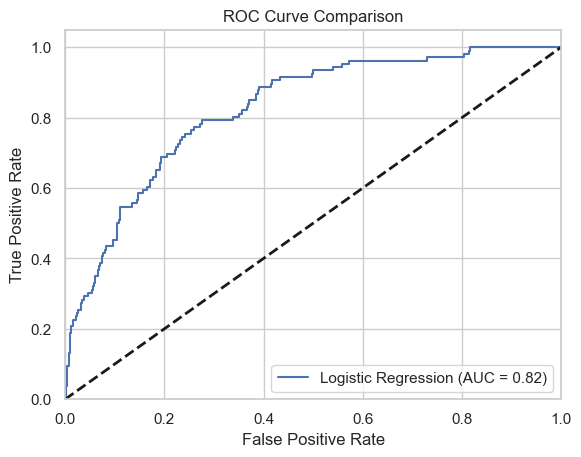

In [13]:
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=42))])
lr_model.fit(X_train, y_train)

models = {'Random Forest': rf_model, 'Logistic Regression': lr_model}
results = {}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(10)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.figure(10)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()